<a href="https://colab.research.google.com/github/thomasrodriguez10/Google-Colab/blob/main/TransferLearning_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Part 2: Fine Tunning
* Can leverage an existing neural network proven to work on similar problems similar to our own
* Can leverage a working network architecture which has already learned patterns on similar data to our own (often results in greate results with less data)

## What we're going to cover
* Introduce fine-tuning transfer learning with TensorFlow
* Introduce the Keras Functional API to build models
* Using a small dataset to experiment faster
* Data augmentation (making your training set more diverse without adding samples)
* Running a series of experiments on our Food Vision data
* Introduce the ModelCheckPoint callback to save intermediate training results

In [ ]:
# Check if we are using a gpu
!nvidia-smi

Mon Dec 12 16:25:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

in previous notebooks, we've created a bunch of helper functions. Now, we have to called them

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-12 16:25:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-12 16:25:11 (62.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

**Note:** If you're running this notebook in Google Colab. when it times out Colab will delete 'helper_functions.py'. so you will have to redownload it if you want access to your helper functions

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our problem

In [ ]:
# Get 10% of training data of 10 classes of food
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-12-12 16:25:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  38.3MB/s    in 4.8s    

2022-12-12 16:25:25 (33.8 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"



In [ ]:
from tensorflow.python import train
import tensorflow as tf
IMG_SIZE  = (224,224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = "categorical",
    batch_size = BATCH_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.00000000e+01 5.00000000e+00 0.00000000e+00]
   [1.00000000e+01 5.00000000e+00 0.00000000e+00]
   [1.10000000e+01 6.00000000e+00 0.00000000e+00]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[1.03316326e+01 5.33163261e+00 0.00000000e+00]
   [1.00000000e+01 5.00000000e+00 0.00000000e+00]
   [1.02142859e+01 5.21428585e+00 0.00000000e+00]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  [[1.10765305e+01 6.07653046e+00 7.65306503e-02]
   [1.00153065e+01 5.01530600e+00 0.00000000e+00]
   [1.00000000e+01 5.00000000e+00 0.00000000e+00]
   ...
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]
   [7.00000000e+00 2.00000000e+00 0.00000000e+00]]

  ...

  [[6.41833878e+00 7.98981094e+00 5.20407486e+00]
   [8

## Model 0: Building a transfer learning model using Keras Function API

The sequential API is straight-foward, it runs our layers in sequential order

The functional API gives us more flexibility with our models

In [ ]:
# 1. Create base model
base_model = tf.keras.applications.EfficientNetB0(
    include_top = False
)
# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling()(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling 2d: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "outputlayer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 10. fit the model
history_10_percent = model_0.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [create_tensorboard_callback(
        dir_name = "transfer_learning",
        experiment_name = "10_percente_feature_extraction"
    )]
)

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model (None, 7, 7, 1280)
Shape after GlobalAveragePooling 2d: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percente_feature_extraction/20221212-162533
Epoch 1/5
24/24 [==============================] - 19s 262ms/step - loss: 1.8692 - accuracy: 0.4293 - val_loss: 1.2880 - val_accuracy: 0.7286
Epoch 2/5
24/24 [==============================] - 5s 187ms/step - loss: 1.0889 - accuracy: 0.7773 - val_loss: 0.8504 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 4s 152ms/step - loss: 0.7743 - accuracy: 0.8387 - val_loss: 0.6698 - val_accuracy: 0.8438
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6296 - accuracy: 0.8640 - val_loss: 0.5903 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 4s 150ms/step - loss: 0.5392 - accuracy: 0.8813 - val_loss: 0.5423 - val_accuracy: 0.8865


In [ ]:
# Evaluate on the full test data
model_0.evaluate(test_data)

79/79 [==============================] - 6s 76ms/step - loss: 0.5466 - accuracy: 0.8620


[0.546603262424469, 0.8619999885559082]

In [ ]:
# Check the layer in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [ ]:
# How about we get a summary of the base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 outputlayer (Dense)         (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


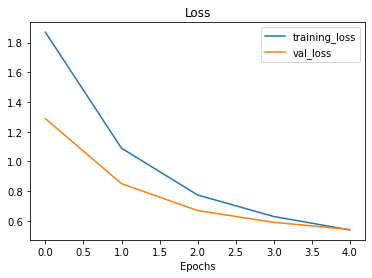

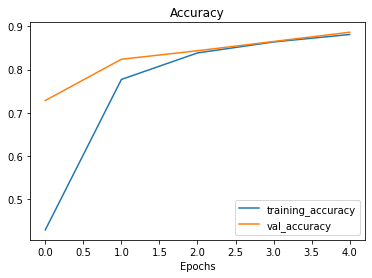

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

we have a tensor after our model goes through "base model" of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePoolin2D (None, 1280)

Let's use similar shaped tensor of (1,4,43) and then passes it to GlobalAveragePooling2D

In [ ]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input Tensor: \n {input_tensor}\n")

# pass the random tensor through a random global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}")

# Check the shape of the different tensor
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input Tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]
Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction learning is name how it is is because what often happens is pretrained model outputs a feature vector ( a long tensor of numbers which represents the learned represention of the model on a particular sample, in our case, this is the output of the tf.keras.layers.GlobalAveragePooling2D() layer) which can then be used to extract patterns out of for our own specific problems


## What is a feature vector?
* a feature vector is learned representation of the input data (a compressed form of the input data based on how the model see's it)


## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... let's setup some experiments

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the trainig data with data augmentation 

**Note:** throughout all experiments the same test dataset will be use to evaluate our model... this ensures consistency across evaluation metrics.



In [ ]:
# Download and unzip data - preprocessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2022-12-12 16:26:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  35.4MB/s    in 4.2s    

2022-12-12 16:26:35 (30.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1 = "10_food_classes_1_percent/test"

In [ ]:
# How many images are working with?
walk_through_dir("10_food_classes_1_percent")


There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

## Getting and preprocessing data for model_1

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_1_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE # Default = 32
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

After reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster than the CPU)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [ ]:
# import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name = "data_augmentation")

In [ ]:
print(tf.__version__)

2.9.2


### Visualize our data augmentation layer (and see what happens to our data)

In [ ]:
# View a random image and compare to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")

# Augmented
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0),training = True)
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.imshow(tf.squeeze(augmented_img)/255.)


Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(
    shape = input_shape,
    name = "input_layer"
)

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base model the inputs after augmentaition
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

# Put a dense layer as the ouput
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_1_percent = model_1.fit(
    train_data_1_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    # Track model training logs
    callbacks = [
        create_tensorboard_callback(
            dir_name = "transfer_learning",
            experiment_name = "1_percent_data_aug"
        )
    ]
)

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20221212-172729
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.2646 - accuracy: 0.1571

3/3 [==============================] - 11s 2s/step - loss: 2.2646 - accuracy: 0.1571 - val_loss: 2.1891 - val_accuracy: 0.2188
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.0096 - accuracy: 0.3000 - val_loss: 2.0412 - val_accuracy: 0.3191
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.8338 - accuracy: 0.4143 - val_loss: 1.9410 - val_accuracy: 0.3701
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.6542 - accuracy: 0.6000 - val_loss: 1.8343 - val_accuracy: 0.4227
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.4690 - accuracy: 0.8000 - val_loss: 1.7477 - val_accuracy: 0.4605


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full set of data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.7441 - accuracy: 0.4808


[1.744128942489624, 0.48080000281333923]

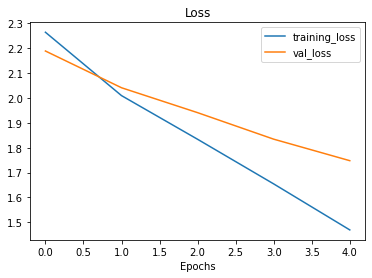

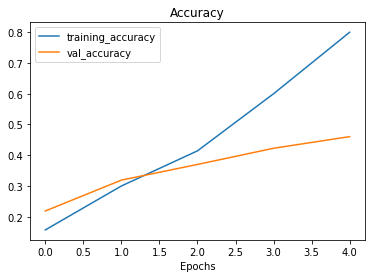

In [ ]:
# How do the model with 1% of the the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

# Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [ ]:
# Get 10 of data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-12-12 19:00:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.145.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.3’

10_food_classes_10_ 100%[===================>] 160.74M  35.1MB/s    in 5.1s    

2022-12-12 19:00:11 (31.5 MB/s) - ‘10_food_classes_10_percent.zip.3’ saved [168546183/168546183]



In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = "categorical",
    image_size = IMG_SIZE
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# How many images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, 3)           0         
                                                                 
 random_rotation (RandomRota  (None, None, 3)          0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, None, 3)           0         
                                                                 
 random_height (RandomHeight  (None, None, 3)          0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, None, 3)           0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [ ]:

# Create model 2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
    # preprocessing Rescalling(1./255) if you are using ResNet you need to Rescall

], name = "data_augmentation" )

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in be)
inputs = layers.Input(shape = input_shape, name = "input_layer" )
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training = False) # pass the augmented images to base model but keep the model the same "no training"
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2")

# Compile
model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint Callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start whe we left off



In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback taht saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = True,
    save_best_only = False,
    save_freq = "epoch", # Save every epoch
    verbose = 1
)

### Fit model 2 passing in the ModelCheckpoint callback


In [ ]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(
    train_data_10_percent,
    epochs = initial_epochs,
    validation_data = test_data,
    validation_steps = int(0.25 * len(test_data)),
    callbacks = [
        create_tensorboard_callback(
            dir_name = "transfer_learning",
            experiment_name = "10_percent_data_aug"
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20221212-210819
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0716 - accuracy: 0.2867
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 13s 502ms/step - loss: 2.0716 - accuracy: 0.2867 - val_loss: 1.5127 - val_accuracy: 0.6464
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3499 - accuracy: 0.6800
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 412ms/step - loss: 1.3499 - accuracy: 0.6800 - val_loss: 1.0252 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0160 - accuracy: 0.7413
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 370ms/step - loss: 1.0160 - accuracy: 0.7413 - val_loss: 0.8031 - val_accuracy: 0.8388
Ep

In [ ]:
# What were model_0 results
model_0.evaluate(test_data)

79/79 [==============================] - 8s 91ms/step - loss: 0.5466 - accuracy: 0.8620


[0.5466032028198242, 0.8619999885559082]

In [ ]:
# Check model_2 results on all test_data

results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 87ms/step - loss: 0.6319 - accuracy: 0.8448


[0.6319211721420288, 0.8447999954223633]

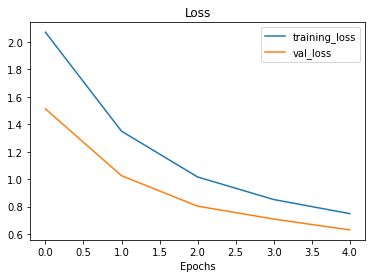

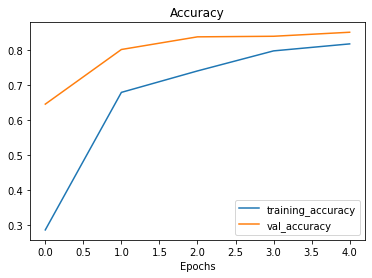

In [ ]:
# Plot model loss cuves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluated model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weigths 
loaded_weights_models_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6319 - accuracy: 0.8448


In [ ]:
# If the results from our previosly evaluated model_2 match the loaded weights, everything went according to plan!
results_10_percent_data_aug == loaded_weights_models_results

True

## Model 3: Fine-tuning an existing model on 10% of the data

**Note:** Fine-tunning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
# Layers in our loaded model
model_2.layers

In [ ]:
# Are these layers trainables
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fb3e644b340> True
<keras.engine.sequential.Sequential object at 0x7fb3e644c640> True
<keras.engine.functional.Functional object at 0x7fb3e6a55340> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fb3e645fa30> True
<keras.layers.core.dense.Dense object at 0x7fb3e69cf6a0> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name, layer.trainable)

0 input_10 False
1 rescaling_9 False
2 normalization_9 False
3 tf.math.truediv_9 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squee